In [1]:
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import re
import requests
from bs4 import BeautifulSoup
res = requests.get("https://www.pro-football-reference.com/years/2021/scrimmage.htm")
soup = BeautifulSoup(res.text,features='html.parser')

tbody = soup.find_all("tbody")[-1]

usernames = []

for tr in tbody.find_all("tr"):
    if(tr.get("class") is not None and tr.get("class")[0] == "thead"):
        continue
    first = tr.td
    a = first.a
    pos = first.next_sibling.next_sibling.next_sibling.text.lower()
    if(pos != ""):
        username = re.search("\/(.{6}\d{2}).htm", a.get("href")).group(1)
        usernames.append((username, pos))
#usernames

In [2]:
def get_df(username):
    url = "https://www.pro-football-reference.com/players/K/" + username + "/gamelog/"
    df = pd.read_html(url, header=1)[0]
    df = df.head(df.shape[0] - 1)
    df = df[df['Date'] != "Date"]
    df = df[df['GS'] != "Did Not Play"]
    df = df[df['GS'] != "Inactive"]
    df = df[df['GS'] != "Injured Reserve"]
    df = df[df['GS'] != "COVID-19 List"]
    df.drop(columns=["GS"])
    return df

In [3]:
df_jt = get_df(usernames[0][0])
df_kupp = get_df(usernames[1][0])
df_hurts = get_df(usernames[79][0])

In [4]:
# Adjusted Yards per pass attempt: (PassingYds + 20PassTD - 45Int)/(Passes attempted)
def get_rec_df(df):
    df_rec = pd.DataFrame(columns=['Year','Date','Week','Team','Opp','Location',
                                      'Tgt','Rec','RecYd','RecTD','Catch%','RecYd/Tgt',
                                      'RshAtt','RshYd','RshYd/Att','RshTD',
                                      'Cmp','PassAtt','Cmp%','PassYd','PassTD','Int','QBRating','TimesSacked','PassYd/Att','AdjPassYd/Att'
                                     ])

    for index,row in df.iterrows():
        loc = ""
        if row['Unnamed: 7'] == "@":
            loc = "A"
        else:
            loc = "H"
        df_rec.loc[index] = [row['Year'],row['Date'],row['Week'],row['Tm'],row['Opp'],loc,
                                row['Tgt'],row['Rec'],row['Yds'],row['TD'],row['Ctch%'],row['Y/Tgt'],
                                row['Att'],row['Yds.1'],row['Y/A'],row['TD.1'],
                                row['Cmp'],row['Att.1'],row['Cmp%'],row['Yds.2'],row['TD.2'],row['Int'],row['Rate'],row['Sk'],row['Y/A.1'],row['AY/A']
                               ]
                             
    df_rec = df_rec.fillna(0)
    return df_rec
df2 = get_rec_df(df_kupp)
df2.head(5)

,Year,Date,Week,Team,Opp,Location,Tgt,Rec,RecYd,RecTD,Catch%,RecYd/Tgt,RshAtt,RshYd,RshYd/Att,RshTD,Cmp,PassAtt,Cmp%,PassYd,PassTD,Int,QBRating,TimesSacked,PassYd/Att,AdjPassYd/Att
0,2017,2017-09-10,1,LAR,IND,H,6,4,76,1,66.7%,12.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017,2017-09-17,2,LAR,WAS,H,6,3,33,0,50.0%,5.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017,2017-09-21,3,LAR,SFO,A,2,2,17,0,100.0%,8.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017,2017-10-01,4,LAR,DAL,A,7,5,60,1,71.4%,8.57,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017,2017-10-08,5,LAR,SEA,H,8,3,44,0,37.5%,5.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
def get_qb_df(df):
    df_qb = pd.DataFrame(columns=['Year','Date','Week','Team','Opp','Location',
                                      'Tgt','Rec','RecYd','RecTD','Catch%','RecYd/Tgt',
                                      'RshAtt','RshYd','RshYd/Att','RshTD',
                                      'Cmp','PassAtt','Cmp%','PassYd','PassTD','Int','QBRating','TimesSacked','PassYd/Att','AdjPassYd/Att'
                                     ])
    for index,row in df.iterrows():
        loc = ""
        if row['Unnamed: 7'] == "@":
            loc = "A"
        else:
            loc = "H"

        df_qb.loc[index] = [row['Year'],row['Date'],row['Week'],row['Tm'],row['Opp'],loc,
                                row['Tgt'],row['Rec'],row['Yds.2'],row['TD.2'],row['Ctch%'],row['Y/Tgt'],
                                row['Att.1'],row['Yds.1'],row['Y/A.1'],row['TD.1'],
                                row['Cmp'],row['Att'],row['Cmp%'],row['Yds'],row['TD'],row['Int'],row['Rate'],row['Sk'],row['Y/A'],row['AY/A']
                               ]
    df_qb = df_qb.fillna(0)
    return df_qb
df3 = get_qb_df(df_hurts)
df3.head(5)

,Year,Date,Week,Team,Opp,Location,Tgt,Rec,RecYd,RecTD,Catch%,RecYd/Tgt,RshAtt,RshYd,RshYd/Att,RshTD,Cmp,PassAtt,Cmp%,PassYd,PassTD,Int,QBRating,TimesSacked,PassYd/Att,AdjPassYd/Att
1,2020,2020-09-20,2,PHI,LAR,H,0,0,0,0,0.0%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2020,2020-09-27,3,PHI,CIN,H,0,0,5,0,0.0%,0,2,0,2.50,0,0,0,0,0,0,0,0,0,0,0
3,2020,2020-10-04,4,PHI,SFO,A,0,0,18,0,0.0%,0,3,0,6.00,0,0,0,0,0,0,0,0,0,0,0
4,2020,2020-10-11,5,PHI,PIT,A,0,0,0,0,0.0%,0,0,0,0,0,1,1,100.00,18,0,0,118.7,0,18.00,18.00
5,2020,2020-10-18,6,PHI,BAL,H,1,1,23,0,100.0%,3.00,2,0,11.50,0,0,0,0,0,0,0,0,0,0,0


In [6]:
def get_rb_df(df):
    df_rb = pd.DataFrame(columns=['Year','Date','Week','Team','Opp','Location',
                                      'Tgt','Rec','RecYd','RecTD','Catch%','RecYd/Tgt',
                                      'RshAtt','RshYd','RshYd/Att','RshTD',
                                     ])
    for index,row in df.iterrows():
        loc = ""
        if row['Unnamed: 7'] == "@":
            loc = "A"
        else:
            loc = "H"

        df_rb.loc[index] = [row['Year'],row['Date'],row['Week'],row['Tm'],row['Opp'],loc,
                                row['Tgt'],row['Rec'],row['Yds.1'],row['TD.1'],row['Ctch%'],row['Y/Tgt'],
                                row['Att'],row['Yds'],row['Y/A'],row['TD'],
                               ]
    df_rb = df_rb.fillna(0)
    return df_rb
df4 = get_rb_df(df_jt)
df4.head(5)

,Year,Date,Week,Team,Opp,Location,Tgt,Rec,RecYd,RecTD,Catch%,RecYd/Tgt,RshAtt,RshYd,RshYd/Att,RshTD
0,2020,2020-09-13,1,IND,JAX,A,6,6,67,0,100.0%,11.17,9,22,2.44,0
1,2020,2020-09-20,2,IND,MIN,H,2,2,9,0,100.0%,4.50,26,101,3.88,1
2,2020,2020-09-27,3,IND,NYJ,H,1,1,3,0,100.0%,3.00,13,59,4.54,1
3,2020,2020-10-04,4,IND,CHI,A,1,1,11,0,100.0%,11.00,17,68,4.00,0
4,2020,2020-10-11,5,IND,CLE,A,3,2,17,0,66.7%,5.67,12,57,4.75,1


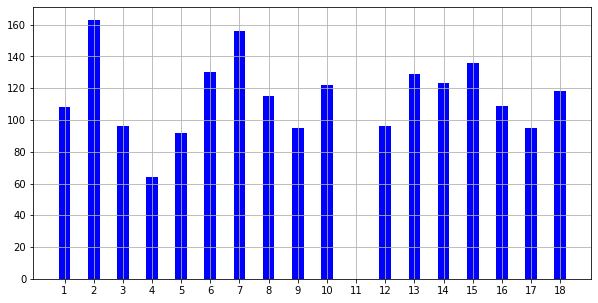

In [7]:
kupp = df2[df2['Year'] == "2021"]
lst_week = []
lst_yd = []
for index,row in kupp.iterrows():
    lst_week.append(int(row['Week']))
    lst_yd.append(int(row['RecYd']))
fig = plt.figure(figsize = (10, 5))
plt.bar(lst_week, lst_yd, color = 'blue',width=0.4)
plt.grid(True)
plt.xticks(range(1, 19))       
plt.show()